In [1]:
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from get_station_data import ghcnd

import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

import torch

crs = ccrs.PlateCarree()
%matplotlib inline 

/Users/magnus/miniconda3/envs/deepsensorgallery/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import deepsensor.torch
from deepsensor.train.train import set_gpu_default_device

use_gpu = False
if use_gpu:
    set_gpu_default_device()

/Users/magnus/miniconda3/envs/deepsensorgallery/lib/python3.10/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/Users/magnus/miniconda3/envs/deepsensorgallery/lib/python3.10/site-packages/fdm/fdm.py:44: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  / np.math.factorial(order)
/Users/magnus/miniconda3/envs/deepsensorgallery/lib/python3.10/site-packages/fdm/fdm.py:38: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  coefs = mat.inv()[:, deriv] * np.math.factorial(deriv)
/Users/magnus/miniconda3/envs/deepsensorgallery/lib/python3.10/site-packages/fdm/fdm.py:44: DeprecationWarning: `

In [4]:
stn_md = ghcnd.get_stn_metadata()
stn_md.lat = stn_md.lat 
stn_md

,station,lat,lon,elev,name,start_year,end_year
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,1949.0,1949.0
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,1961.0,1961.0
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,1944.0,2023.0
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,1983.0,2023.0
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,1983.0,2023.0
...,...,...,...,...,...,...,...
124949,ZI000067969,-21.0500,29.3670,861.0,WEST NICHOLSON,1962.0,1990.0
124950,ZI000067975,-20.0670,30.8670,1095.0,MASVINGO,1951.0,2023.0
124951,ZI000067977,-21.0170,31.5830,430.0,BUFFALO RANGE,1968.0,1990.0
124952,ZI000067983,-20.2000,32.6160,1132.0,CHIPINGE,1951.0,2020.0


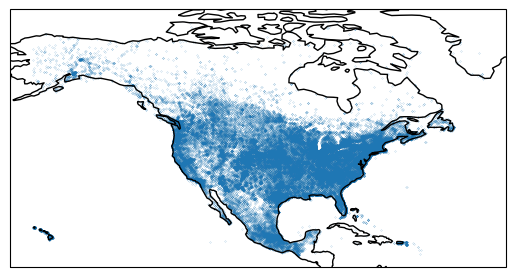

In [5]:
def get_usa_stations(stn_md):
    """
    Uses approx latitude and longitude values to get stations in mainland USA.
    """
    min_lat = 15.0
    max_lat = 75.0
    min_lon = -160.0
    max_lon = -45
    return stn_md[(min_lat <= stn_md.lat) & (stn_md.lat <= max_lat)
                  &(min_lon <= stn_md.lon) & (stn_md.lon <= max_lon)]

stn_md_usa = get_usa_stations(stn_md)


# Split the DataFrame into two subsets

fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
ax.scatter(stn_md_usa.lon, stn_md_usa.lat, s=0.01)
ax.coastlines()


We are no going to select a subset of these stations to model, since there are a few too many to work with here for a demo, let's try look at 5000. 

For now we are just going to look at the variable TMAX, which is the maximum temperature recorded over the day, and only in 2013-2014

In [6]:
stn_md_usa_shuffled = stn_md_usa.sample(frac=1, random_state=43)  # Use random_state for reproducibility

n_stations = 5000
all_stations_md = stn_md_usa_shuffled[:n_stations]

date_range = ( "2013-01-01",  "2014-12-31")
all_raw_station_data= ghcnd.get_data(all_stations_md, include_flags=False, element_types=["TMAX"], date_range=date_range)

# change to degrees to K
all_raw_station_data = all_raw_station_data.rename({"date": "time"}, axis=1)
all_raw_station_data["value"] += 273.15
all_raw_station_data

,station,element,value,time,lon,lat,elev,name
192004,USC00034106,TMAX,273.75,2013-01-01,-92.9158,36.4194,253.0,AR LEAD HILL
192010,USC00034106,TMAX,273.75,2013-01-02,-92.9158,36.4194,253.0,AR LEAD HILL
192016,USC00034106,TMAX,274.25,2013-01-03,-92.9158,36.4194,253.0,AR LEAD HILL
192022,USC00034106,TMAX,277.55,2013-01-04,-92.9158,36.4194,253.0,AR LEAD HILL
192028,USC00034106,TMAX,279.85,2013-01-05,-92.9158,36.4194,253.0,AR LEAD HILL
...,...,...,...,...,...,...,...,...
222031,USC00429111,TMAX,270.95,2014-12-27,-109.5356,40.4400,1629.2,UT VERNAL
222038,USC00429111,TMAX,267.55,2014-12-28,-109.5356,40.4400,1629.2,UT VERNAL
222045,USC00429111,TMAX,270.35,2014-12-29,-109.5356,40.4400,1629.2,UT VERNAL
222052,USC00429111,TMAX,270.35,2014-12-30,-109.5356,40.4400,1629.2,UT VERNAL


Unfortunateley not all the stations have data for all times, we can look at the number of unique staion IDs to see how many we have.

Only ~600 have data, let's use some of these for training and the rest for validation.

In [7]:
len(pd.unique(all_raw_station_data.name))


638

In [8]:
# Filter metadata to only include stations that have data
all_stations_md = all_stations_md[all_stations_md.name.isin(all_raw_station_data.name)]

/Users/magnus/miniconda3/envs/deepsensorgallery/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


We can visualise this with the all the stations to see how our sample compares.

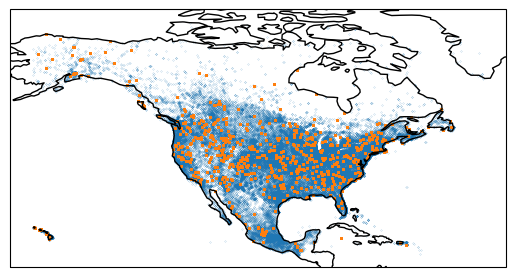

In [9]:
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=crs))
ax.scatter(stn_md_usa.lon, stn_md_usa.lat, s=0.01)
ax.scatter(all_raw_station_data.lon, all_raw_station_data.lat, s=1)
ax.coastlines()

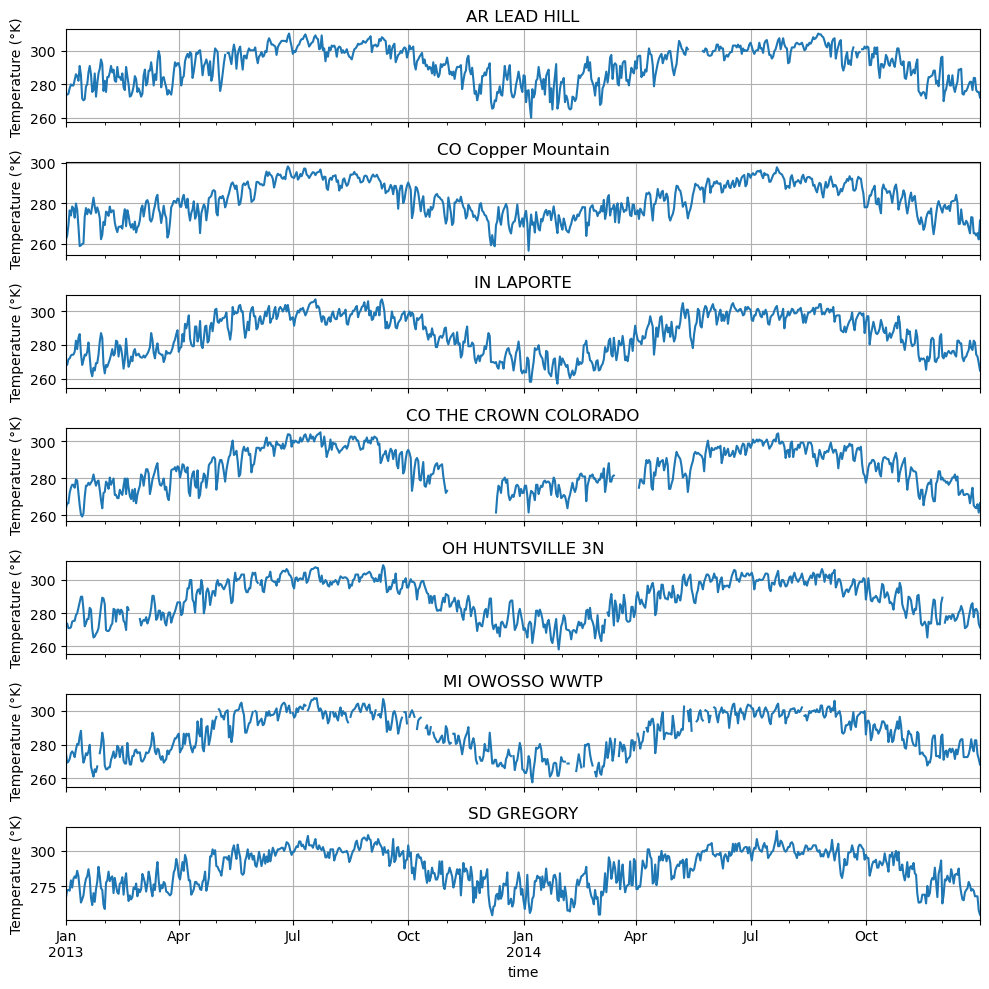

In [10]:
station_pivot_df = all_raw_station_data.pivot(index='time', columns='name', values='value')

stations = all_stations_md.name

fig, axes = plt.subplots(7, 1, figsize=(10, 10 ), sharex=True)

for i, (station, ax) in enumerate(zip(stations, axes)):
    station_pivot_df[station].plot(ax=ax)
    ax.set_title(station)
    ax.set_ylabel('Temperature (°K)')
    ax.grid(True)
plt.tight_layout()


In [11]:
all_raw_station_data

,station,element,value,time,lon,lat,elev,name
192004,USC00034106,TMAX,273.75,2013-01-01,-92.9158,36.4194,253.0,AR LEAD HILL
192010,USC00034106,TMAX,273.75,2013-01-02,-92.9158,36.4194,253.0,AR LEAD HILL
192016,USC00034106,TMAX,274.25,2013-01-03,-92.9158,36.4194,253.0,AR LEAD HILL
192022,USC00034106,TMAX,277.55,2013-01-04,-92.9158,36.4194,253.0,AR LEAD HILL
192028,USC00034106,TMAX,279.85,2013-01-05,-92.9158,36.4194,253.0,AR LEAD HILL
...,...,...,...,...,...,...,...,...
222031,USC00429111,TMAX,270.95,2014-12-27,-109.5356,40.4400,1629.2,UT VERNAL
222038,USC00429111,TMAX,267.55,2014-12-28,-109.5356,40.4400,1629.2,UT VERNAL
222045,USC00429111,TMAX,270.35,2014-12-29,-109.5356,40.4400,1629.2,UT VERNAL
222052,USC00429111,TMAX,270.35,2014-12-30,-109.5356,40.4400,1629.2,UT VERNAL


In [12]:
# all_raw_station_data.(["date", "lat", "lon"]).resample('D', on='date').mean()
#make the index of all_raw_station_data into date then lat, lon
all_raw_station_grouped = all_raw_station_data.groupby(["time", "lat", "lon"]).mean()
all_raw_station_grouped

/var/folders/rx/60rbql0x49b20byhsnw62dvr0000gn/T/ipykernel_89593/236965017.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_raw_station_grouped = all_raw_station_data.groupby(["time", "lat", "lon"]).mean()


value    elev
time       lat     lon                      
2013-01-01 16.3000 -91.9667   294.85  1511.8
           16.3667 -91.7000   294.85  1595.9
           17.1333 -92.7000   303.15   659.9
           17.3667 -92.7500   299.25    62.8
           17.6997 -64.8125   302.55    14.0
...                              ...     ...
2014-12-31 66.8125 -141.6200  266.45   673.6
           68.1300 -149.4800  266.35  1463.0
           69.6167 -140.2000     NaN    13.0
           70.0036 -153.0836     NaN    51.2
           71.3214 -156.6111  255.45     4.6

[421460 rows x 2 columns]

As we can see, there is quite a lot of missing data. Fortunately this shouldn't be a problem for us. 

Now let's take a look at the gridded data, which we can acesss using the xarray tutorial.

In [13]:
ds_raw = xr.tutorial.open_dataset("air_temperature")
ds_raw

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [14]:
ds_gridded = ds_raw.resample(time="D").max()


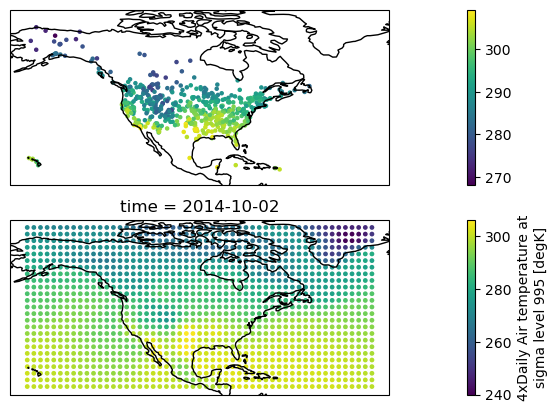

In [15]:
date = pd.to_datetime("2014-10-02")


fig, ax = plt.subplots(2, 1, subplot_kw=dict(projection=crs), figsize=(20, 5), sharex=True, sharey=True)
# # xr.plot.scatter(station_xr.isel(date=-1) + 273, y="lat", x="lon", hue="value")
im1 = ax[0].scatter(all_raw_station_data.lon[all_raw_station_data.time == date],
                    all_raw_station_data.lat[all_raw_station_data.time == date], s=5, c=all_raw_station_data.value[all_raw_station_data.time == date])
ax[0].coastlines()
plt.colorbar(im1, ax=ax[0])

xr.plot.scatter(ds_raw.sel(time=date), y="lat", x="lon", hue="air", ax=ax[1], s=20)
ax[1].coastlines()

In [16]:
from deepsensor.data.processor import DataProcessor

data_processor = DataProcessor(x1_name="lat", x2_name="lon")
era5_ds, station_df, aux_station_elev_df  = data_processor([ds_gridded, all_raw_station_grouped.value,all_raw_station_grouped.elev])
print(data_processor)

DataProcessor with normalisation params:
{'air': {'method': 'mean_std',
         'param1': 283.0553283691406,
         'param2': 15.767019271850586},
 'coords': {'time': {'name': 'time'},
            'x1': {'map': (0.0, 1.0), 'name': 'lat'},
            'x2': {'map': (0.0, 1.0), 'name': 'lon'}},
 'elev': {'method': 'mean_std',
          'param1': 706.010605988706,
          'param2': 783.5834355550701},
 'value': {'method': 'mean_std',
           'param1': 288.8078989966786,
           'param2': 12.537787259619268}}


In [17]:
from deepsensor.data.loader import TaskLoader

task_loader = TaskLoader(context=[era5_ds, aux_station_elev_df], target=station_df)
task_loader.load_dask()
print(task_loader)

TaskLoader(2 context sets, 1 target sets)
Context variable IDs: (('air',), ('elev',))
Target variable IDs: (('value',),)


In [18]:
import deepsensor.torch
from deepsensor.model.convnp import ConvNP

model = ConvNP(data_processor, task_loader, unet_channels=(32,)*4, points_per_unit=64, likelihood="gnp")

dim_yc inferred from TaskLoader: (1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 0
encoder_scales inferred from TaskLoader: [1.25, 0.0078125]
decoder_scale inferred from TaskLoader: 0.015625


In [19]:
from tqdm import tqdm

In [20]:
# from tqdm import tqdm
train_tasks = []
train_dates = pd.date_range("2013-01-01", "2014-10-31")
val_dates = pd.date_range("2014-11-01", "2014-12-31")

for date in tqdm(train_dates):
    task = task_loader(date, context_sampling="all", target_sampling="all")
    train_tasks.append(task)

val_tasks = []
for date in tqdm(val_dates):
    task = task_loader(date, context_sampling="all", target_sampling="all")
    val_tasks.append(task)

100%|██████████| 61/61 [00:00<00:00, 187.21it/s]


100%|██████████| 669/669 [00:02<00:00, 332.41it/s]
100%|██████████| 61/61 [00:00<00:00, 345.39it/s]

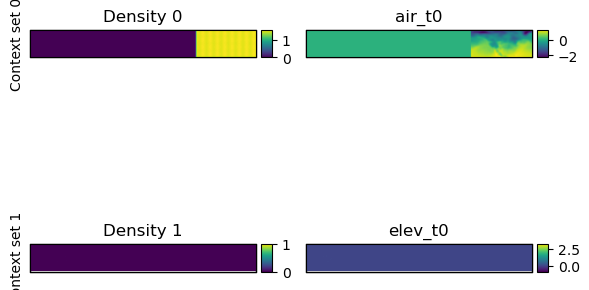

In [21]:
fig = deepsensor.plot.context_encoding(model, val_tasks[2], task_loader)


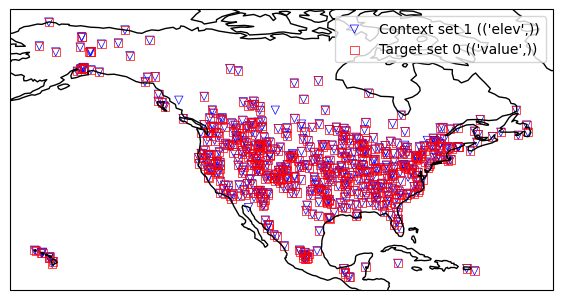

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw=dict(projection=crs))
ax.coastlines()
# ax.add_feature(cf.BORDERS)
deepsensor.plot.offgrid_context(ax, task_loader("2013-02-05"), data_processor, task_loader, plot_target=True, add_legend=True, linewidths=0.5)
plt.show()
fig.savefig("train_stations.png", bbox_inches="tight")

In [23]:
import lab as B
def compute_val_loss(model, val_tasks):
    val_losses = []
    for task in val_tasks:
        val_losses.append(B.to_numpy(model.loss_fn(task, normalise=True)))
    return np.mean(val_losses)

In [24]:
from tqdm import tqdm
from deepsensor.train.train import train_epoch

n_epochs = 80
train_losses = []
val_losses = []

val_loss_best = np.inf

for epoch in tqdm(range(n_epochs)):
    batch_losses = train_epoch(model, train_tasks)
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    val_loss = compute_val_loss(model, val_tasks)
    val_losses.append(val_loss)

    if val_loss < val_loss_best:
        import torch
        import os
        val_loss_best = val_loss
        folder = "models/downscaling/"
        if not os.path.exists(folder): os.makedirs(folder)
        torch.save(model.model.state_dict(), folder + f"model.pt")

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(train_losses, label="train")
ax.plot(val_losses, label="val")
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("loss.png", bbox_inches="tight")